# Segmentation of Indian Traffic

#### UNet and Custom CANet for Semantic Segmentation

This project implements two semantic segmentation models to analyze Indian traffic scenes. The first model is based on the well-known UNet architecture, while the second is a custom-designed CANet.

The project was inspired by real-world image segmentation tasks. Its goal is to serve as both a practical application and a learning exercise in deep learning and computer vision.

## Dataset
This project uses the India Driving Dataset from [idd.insaan.iiit.ac.in](https://idd.insaan.iiit.ac.in/), a dataset consists of images obtained from a front facing camera attached to a car. The car was driven around Hyderabad, Bangalore cities and their outskirts. Each image is accompanied by a JSON file containing detailed metadata and annotations.

## Workflow Overview
1. Data Preprocessing – Reading and organizing the image and annotation data
2. Data Vectorization – Label remapping and data augmentation
3. Model Training – Training the UNet
4. Evaluation – Assessing model performance on validation data
5. Inference – Segmenting new images using trained models
6. Custom CANet Implementation – Designing, training, evaluating, and deploying a custom CANet architecture

## Implementation

### 1. Data preprocessing

#### 1.1 Importing libraries

In [2]:
# Plotting
import matplotlib.pyplot as plt
%matplotlib inline

# Data Handling
import pandas as pd
import numpy as np
import os
import warnings
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  # '2' hides warnings; '3' hides all logs
from os import path
from tqdm import tqdm
from PIL import Image, ImageDraw
from PIL import ImagePath
import json

#Vecotrizing
import albumentations as A
import imgaug.augmenters as iaa
from imgaug.augmentables.segmaps import SegmentationMapsOnImage

# Neural Network
os.environ["SM_FRAMEWORK"] = "tf.keras"
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import UpSampling2D
from tensorflow.keras.layers import MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.layers import Multiply
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
K.set_image_data_format('channels_last')
import segmentation_models as sm
from segmentation_models import Unet


#Model saving and loading and logging
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import CSVLogger
from keras.models import load_model

# Evaluation
from segmentation_models.metrics import IOUScore

E0000 00:00:1748689729.738005    5757 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748689729.767195    5757 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1748689730.023219    5757 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748689730.023251    5757 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748689730.023254    5757 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1748689730.023257    5757 computation_placer.cc:177] computation placer already registered. Please check linka

Segmentation Models: using `tf.keras` framework.


#### 1.2 Reading the data

In [3]:
# read the file path and returns a dataframe with all the paths
def return_file_names_df(split):
    """
    Returns a DataFrame containing paths to images and their corresponding annotation files.

    Parameters:
    ----------
    split : str
        Dataset split to use. Should be either 'train' or 'val', corresponding to
        the folder names under 'leftImg8bit' and 'gtFine'.

    Returns:
    -------
    pd.DataFrame
        A DataFrame with two columns:
            - 'image': path to the image file
            - 'json': path to the corresponding annotation file (in JSON format)
    """
    # temporary sets which appended to
    image_names = set()
    mask_names = set()
    # Collect image paths
    for i in os.listdir("IDD_Segmentation/leftImg8bit/" + split):
        for image in os.listdir("IDD_Segmentation/leftImg8bit/" + split + '/' + i):
            image_names.add("IDD_Segmentation/leftImg8bit/" + split + '/' + i + '/' + image)
            
    # Collect mask (JSON) paths
    for i in os.listdir("IDD_Segmentation/gtFine/" + split):
        for image in os.listdir("IDD_Segmentation/gtFine/"  + split + '/' + i):
            mask_names.add("IDD_Segmentation/gtFine/" + split + '/' + i + '/' + image)
            
    # Sort to align images with their masks
    image_names = sorted(image_names)
    mask_names = sorted(mask_names)
    
    data_df = pd.DataFrame(zip(image_names, mask_names), columns=['image','json'])
    return data_df

In [4]:
# same function as above, but without the JSON as there is none
def return_file_names_test():
    """
    Returns a DataFrame containing paths to images and their corresponding annotation files only for test data.

    Returns:
    -------
    pd.DataFrame
        A DataFrame with two columns:
            - 'image': path to the image file
    """
    image_names = set()
    for i in os.listdir("IDD_Segmentation/leftImg8bit/test/"):
        for image in os.listdir("IDD_Segmentation/leftImg8bit/test/" + i):
            image_names.add("IDD_Segmentation/leftImg8bit/test/" + i + '/' + image)

    image_names = sorted(image_names)

    data_df = pd.DataFrame(image_names, columns=['image'])
    return data_df

In [5]:
# running the function and preview
data_train = return_file_names_df('train')
data_train.head()

,image,json
0,IDD_Segmentation/leftImg8bit/train/0/005506_le...,IDD_Segmentation/gtFine/train/0/005506_gtFine_...
1,IDD_Segmentation/leftImg8bit/train/0/005626_le...,IDD_Segmentation/gtFine/train/0/005626_gtFine_...
2,IDD_Segmentation/leftImg8bit/train/0/006741_le...,IDD_Segmentation/gtFine/train/0/006741_gtFine_...
3,IDD_Segmentation/leftImg8bit/train/0/006861_le...,IDD_Segmentation/gtFine/train/0/006861_gtFine_...
4,IDD_Segmentation/leftImg8bit/train/0/007325_le...,IDD_Segmentation/gtFine/train/0/007325_gtFine_...


In [6]:
# shape of data
data_train.shape

(6993, 2)

In [7]:
# running the function and preview
data_val = return_file_names_df('val')
data_val.head()

,image,json
0,IDD_Segmentation/leftImg8bit/val/119/035471_le...,IDD_Segmentation/gtFine/val/119/035471_gtFine_...
1,IDD_Segmentation/leftImg8bit/val/119/038937_le...,IDD_Segmentation/gtFine/val/119/038937_gtFine_...
2,IDD_Segmentation/leftImg8bit/val/119/107588_le...,IDD_Segmentation/gtFine/val/119/107588_gtFine_...
3,IDD_Segmentation/leftImg8bit/val/119/171342_le...,IDD_Segmentation/gtFine/val/119/171342_gtFine_...
4,IDD_Segmentation/leftImg8bit/val/119/222715_le...,IDD_Segmentation/gtFine/val/119/222715_gtFine_...


In [8]:
# shape of data
data_val.shape

(981, 2)

In [9]:
data_test = return_file_names_test()
data_test.head()

,image
0,IDD_Segmentation/leftImg8bit/test/103/001262_l...
1,IDD_Segmentation/leftImg8bit/test/103/034557_l...
2,IDD_Segmentation/leftImg8bit/test/103/062258_l...
3,IDD_Segmentation/leftImg8bit/test/103/102482_l...
4,IDD_Segmentation/leftImg8bit/test/103/106599_l...


In [10]:
data_test.shape

(2029, 1)

In [11]:
# saving for later use in inference
data_test.to_csv('data_test.csv', index=False)

#### 1.3 Unique lables

In [12]:
def return_unique_labels(data_df):
    """
    Extracts and counts unique object labels from annotation JSON files.

    Parameters
    ----------
    data_df : pd.DataFrame
        A DataFrame containing a 'json' column with paths to annotation files 
        in JSON format.

    Returns
    -------
        A tuple containing:
        - unique_labels (np.ndarray): Array of unique label names found across all files.
        - label_counts (np.ndarray): Array of corresponding counts for each label.
    """
    # temporary list to append to
    json_list = []
    
    #collecting the labels
    for path in data_df.json.values:
        x = open(path)
        x = json.load(x)
        for objects in x['objects']:
            json_list.append(objects['label'])

    # returning the unique labels and its count
    unique = np.unique(json_list,return_counts=True)
    unique_labels = np.array(unique[0])
    unique_counts = np.array(unique[1])
    return unique_labels, unique_counts

In [13]:
# run the function
unique_labels, unique_counts = return_unique_labels(data_train)

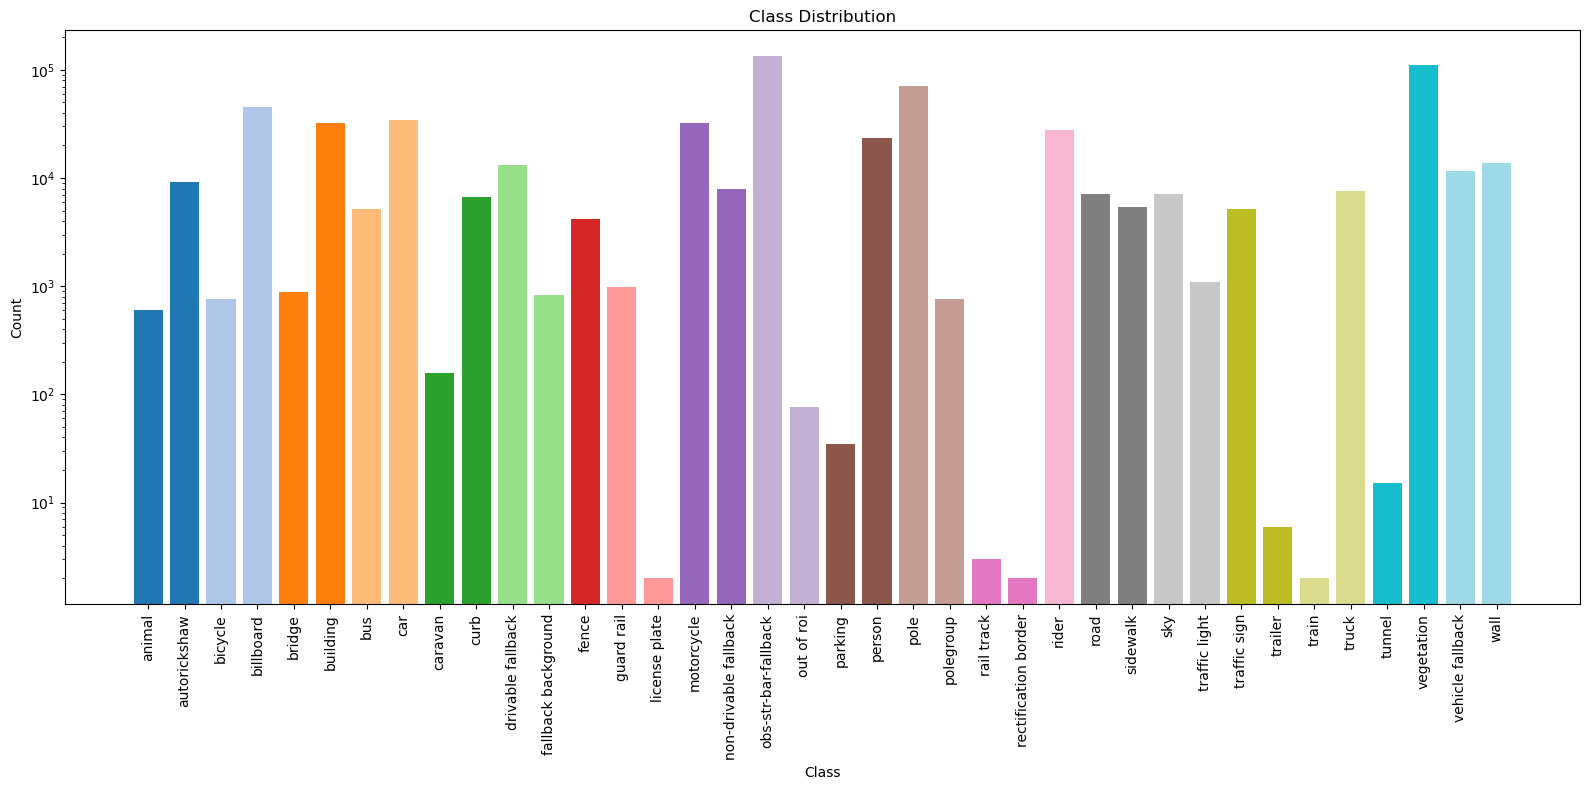

In [14]:
# plotting the distribution of unique labels
plt.close()
# Unique color per bar
colors = plt.cm.tab20(np.linspace(0, 1, len(unique_labels)))
plt.figure(figsize=(16, 8))
plt.bar(unique_labels,unique_counts, color=colors)
# setting the configuration of the plot
plt.yscale('log')
plt.xticks(rotation=90)
plt.title("Class Distribution")
plt.xlabel("Class")
plt.ylabel("Count")
plt.tight_layout()
#showing the plot
plt.show()

In [ ]:
# saving unique labels for later use
np.save('unique_labels.npy', unique_labels)

<img src='https://idd.insaan.iiit.ac.in/static/img/anno_hierarchy.png'>
Based on the label distribution provided by the dataset's official website, the extracted unique labels are used for consistent remapping in subsequent preprocessing steps.

In [ ]:
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

#### 1.4 Getting JSON meta data and generating masks images

In [17]:
def get_poly(file):
    """
    Parses a JSON annotation file and extracts image dimensions, labels, and polygon coordinates For a single image.

    Parameters
    ----------
    file : str
        Path to the JSON annotation file.

    Returns
    -------
    tuple
        A tuple containing:
        - img_width (int): Width of the image.
        - img_height (int): Height of the image.
        - label_list (list of str): List of labels for each object in the image.
        - poly_list (list of list of tuple): List of polygons, each represented as a list of (x, y) points.
    """
    label_list = []
    poly_list = []
    x = open(file)
    x = json.load(x)
    for objects in x['objects']:
        label_list.append(objects['label'])
        poly_list.append([tuple(pt) for pt in objects['polygon']])
    img_height = x['imgHeight']
    img_width = x['imgWidth']
    
    return img_width, img_height, label_list, poly_list

In [18]:
def compute_masks(data_df,split):
    """
    Generates segmentation masks from annotation polygons and saves them as PNG files.

    Parameters
    ----------
    data_df : pd.DataFrame
        A DataFrame containing a 'json' column with paths to annotation files.
    split : str
        The dataset split (e.g., 'train', 'val'), used to construct output directories.

    Returns
    -------
    pd.DataFrame
        The input DataFrame with an additional 'mask' column containing the paths to the generated mask images.

    Notes
    -----
    - Polygons with less than two points or labels not present in `label_clr` are skipped.
    - Output masks are saved in `IDD_Segmentation/mask/{split}/{scene_id}/` with PNG format.
    """
    # list appended to
    mask_list = []
    # looping through json files
    for mask in tqdm(data_df.json.values):
        #getting the tuple containing meta data
        w, h, labels, vertexlist = get_poly(mask)
        # create a blank grayscale image
        img = Image.new("L", (w, h))
        # create a drawing context 
        img1 = ImageDraw.Draw(img)
        # looping through the polygons
        for i, vertex in enumerate(vertexlist):
            # the corresponding label
            label = labels[i]
            if label not in label_clr:
                continue  # Skip labels not in the mapping
            if len(vertex) < 2:
                continue  # Skip polygons with less than 2 points
            # draw the polygons onto the blank grayscale image
            img1.polygon(vertex, fill = label_clr[labels[i]])
            
        # Ensuring the image is in a consistent format.
        img=np.array(img)
        im = Image.fromarray(img)

        # Extract directory name (scene ID) and file stem
        dir_name = os.path.basename(os.path.dirname(mask))  # e.g., '201'
        file_stem = os.path.splitext(os.path.basename(mask))[0]  # e.g., '053923_leftImg8bit'

        # Construct full output path and ensure directory exists
        mask_dir = os.path.join("IDD_Segmentation/mask/" + split + '/', dir_name)
        os.makedirs(mask_dir, exist_ok=True)

        # the full path
        mask_path = os.path.join(mask_dir, file_stem + ".png")
        # saving the image to the path
        im.save(mask_path)
    
        mask_list.append(mask_path)

    # adding new column that have mask paths
    data_df['mask'] = mask_list
    
    
    return data_df

In [28]:
# running and preview
data_val = compute_masks(data_val,'val')
data_val.head()

100%|█████████████████████████████████████████████████████████████████████████████████| 981/981 [00:38<00:00, 25.62it/s]


,image,json,mask
0,IDD_Segmentation/leftImg8bit/val/119/035471_le...,IDD_Segmentation/gtFine/val/119/035471_gtFine_...,IDD_Segmentation/mask/val/119/035471_gtFine_po...
1,IDD_Segmentation/leftImg8bit/val/119/038937_le...,IDD_Segmentation/gtFine/val/119/038937_gtFine_...,IDD_Segmentation/mask/val/119/038937_gtFine_po...
2,IDD_Segmentation/leftImg8bit/val/119/107588_le...,IDD_Segmentation/gtFine/val/119/107588_gtFine_...,IDD_Segmentation/mask/val/119/107588_gtFine_po...
3,IDD_Segmentation/leftImg8bit/val/119/171342_le...,IDD_Segmentation/gtFine/val/119/171342_gtFine_...,IDD_Segmentation/mask/val/119/171342_gtFine_po...
4,IDD_Segmentation/leftImg8bit/val/119/222715_le...,IDD_Segmentation/gtFine/val/119/222715_gtFine_...,IDD_Segmentation/mask/val/119/222715_gtFine_po...


In [29]:
# saving for later use
data_val.to_csv('preprocessed_data_val.csv', index=False)

In [30]:
data_train = compute_masks(data_train,'train')
data_train.head()

100%|███████████████████████████████████████████████████████████████████████████████| 6993/6993 [04:00<00:00, 29.04it/s]


,image,json,mask
0,IDD_Segmentation/leftImg8bit/train/0/005506_le...,IDD_Segmentation/gtFine/train/0/005506_gtFine_...,IDD_Segmentation/mask/train/0/005506_gtFine_po...
1,IDD_Segmentation/leftImg8bit/train/0/005626_le...,IDD_Segmentation/gtFine/train/0/005626_gtFine_...,IDD_Segmentation/mask/train/0/005626_gtFine_po...
2,IDD_Segmentation/leftImg8bit/train/0/006741_le...,IDD_Segmentation/gtFine/train/0/006741_gtFine_...,IDD_Segmentation/mask/train/0/006741_gtFine_po...
3,IDD_Segmentation/leftImg8bit/train/0/006861_le...,IDD_Segmentation/gtFine/train/0/006861_gtFine_...,IDD_Segmentation/mask/train/0/006861_gtFine_po...
4,IDD_Segmentation/leftImg8bit/train/0/007325_le...,IDD_Segmentation/gtFine/train/0/007325_gtFine_...,IDD_Segmentation/mask/train/0/007325_gtFine_po...


In [31]:
# saving for later use
data_train.to_csv('preprocessed_data_train.csv', index=False)

### 2. Data Vectorization

In [3]:

label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

In [4]:
#loading the data
unique_labels = np.load('unique_labels.npy')
data_train = pd.read_csv('preprocessed_data_train.csv')
data_val = pd.read_csv('preprocessed_data_val.csv')

In [5]:
# Configuration
IMG_SIZE = (384,640)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 18

In [6]:
# Build mapping from actual label values to consecutive class indices
label_to_index = {v: i for i, v in enumerate(sorted(set(label_clr.values())))}

In [7]:
# Apply mapping to mask data
def remap_mask(mask_tensor):
    # Initialize a tensor of zeros with the same shape as mask_tensor
    remapped = tf.zeros_like(mask_tensor, dtype=tf.int32)
    
    # Apply the mapping for each label
    for raw_val, new_val in label_to_index.items():
        condition = tf.equal(mask_tensor, raw_val)
        remapped = tf.where(condition, tf.cast(new_val, tf.int32), remapped)
    
    return remapped

In [8]:
# augmentations, ended up not using number 3
aug2 = iaa.Fliplr(1)
#aug3 = iaa.Flipud(1)
aug4 = iaa.Emboss(alpha=(1), strength=1)
aug5 = iaa.DirectedEdgeDetect(alpha=(0.8), direction=(1.0))
aug6 = iaa.Sharpen(alpha=(1.0), lightness=(1.5))

In [9]:
def preprocess(img_path, mask_path, training):
    """
    Preprocesses a single image-mask pair for semantic segmentation.

    Steps:
    1. Reads and decodes the image (PNG) and mask (PNG) from file paths.
    2. Resizes both image and mask to a fixed target size (`IMG_SIZE`).
    3. Optionally applies data augmentation (if `training=True`).
    4. Normalizes the image to [0, 1].
    5. Remaps the mask's pixel values.
    6. Converts the mask to one-hot encoded format.

    Args:
        img_path (tf.Tensor): Path to the input image (PNG).
        mask_path (tf.Tensor): Path to the corresponding segmentation mask (PNG).
        training (bool): Whether the data is being used for training (triggers augmentation).

    Returns:
        img (tf.Tensor): Preprocessed image of shape `(H, W, 3)`.
        mask (tf.Tensor): One-hot encoded mask of shape `(H, W, 18)`.
    """
    # Read and decode image
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMG_SIZE, method='nearest')
    img = tf.cast(img, tf.uint8)  # Keep uint8 for imgaug compatibility

    # Read and decode mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask, tf.uint8)
    mask = tf.squeeze(mask, axis=-1)  # shape (H, W)
    
    # augment if it's training data
    if training:
        img, mask = augment(img, mask)
    else:
        # Normalize only when NOT augmenting
        img = tf.cast(img, tf.float32) / 255.0

    # Remap mask labels
    mask = remap_mask(mask)

    # One-hot encode mask
    mask = tf.one_hot(mask, depth=18)

    return img, mask


def augment(img, mask):
    def _augment_numpy(img_np, mask_np):
        # turning the data to numpy
        img_np = img_np.numpy().astype(np.uint8)
        mask_np = mask_np.numpy().astype(np.uint8)
        # ensuring every augmentation applied to both image and mask
        segmap = SegmentationMapsOnImage(mask_np, shape=img_np.shape)
        # randomly applying augmentation
        a = np.random.uniform()
        if a < 0.25:
            # Geometric: flip left-right -> apply to both
            aug = aug2
            img_aug, segmap_aug = aug(image=img_np, segmentation_maps=segmap)
            mask_aug = segmap_aug.get_arr()
        elif a < 0.5:
            # Image-only emboss: mask unchanged
            img_aug = aug4.augment_image(img_np)
            mask_aug = mask_np
        elif a < 0.75:
            # Image-only DirectedEdgeDetect: mask unchanged
            img_aug = aug5.augment_image(img_np)
            mask_aug = mask_np
        else:
            # Image-only sharpen: mask unchanged
            img_aug = aug6.augment_image(img_np)
            mask_aug = mask_np
        # normalize the data
        img_aug = img_aug.astype(np.float32) / 255.0
        return img_aug, mask_aug.astype(np.uint8)
    # wrap it in a py_function for combatibility
    img, mask = tf.py_function(
        func=_augment_numpy, inp=[img, mask], Tout=[tf.float32, tf.uint8]
    )
    # ensuring the right shape
    img.set_shape([*IMG_SIZE, 3])
    mask.set_shape([*IMG_SIZE]) 
    return img, mask

In [10]:
def get_tf_dataset(X, y, training=True):
    """
    Creates a TensorFlow dataset pipeline for image segmentation tasks.

    This function wraps the image and mask file paths into a `tf.data.Dataset`, applies preprocessing
    (including optional augmentation), batches, and prefetches for efficient training or evaluation.

    Args:
        X (list or tf.Tensor): List or tensor of image file paths.
        y (list or tf.Tensor): List or tensor of corresponding mask file paths.
        training (bool): Flag to enable training-specific behaviors (shuffling, augmentation).

    Returns:
        tf.data.Dataset: A batched and prefetched `tf.data.Dataset` object ready for training or validation.
                         Each batch yields a tuple (images, masks):
                         - images: Tensor of shape (BATCH_SIZE, H, W, 3).
                         - masks: Tensor of shape (BATCH_SIZE, H, W, NUM_CLASSES).
    """
    # initializing the pipeline
    dataset = tf.data.Dataset.from_tensor_slices((X, y))
    
    # Shuffle the dataset for training
    if training:
        dataset = dataset.shuffle(buffer_size=len(X))
        
    # applying the preprocess function
    dataset = dataset.map(lambda img_path, mask_path: preprocess(img_path, mask_path, training), num_parallel_calls=AUTOTUNE)

    # taking a batch
    dataset = dataset.batch(BATCH_SIZE).prefetch(AUTOTUNE)
    
    return dataset

In [11]:
# using the image, mask pairs
X_train = data_train['image']
y_train = data_train['mask']
X_val = data_val['image']
y_val = data_val['mask']

In [12]:
# using only the first 4000 pairs to speed training
X_train = X_train[:4000]
y_train = y_train[:4000]

In [13]:
# Usage:
train_dataset = get_tf_dataset(X_train, y_train, training=True)  # Apply augmentations during training
val_dataset = get_tf_dataset(X_val, y_val, training=False)    # No augmentations during validation

I0000 00:00:1748689747.125582    5757 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9805 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060, pci bus id: 0000:04:00.0, compute capability: 8.6


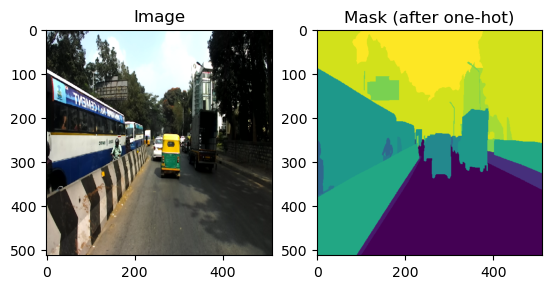

2025-05-25 17:06:32.667951: I tensorflow/core/framework/local_rendezvous.cc:407] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [30]:
# single sample preview
for img, mask in train_dataset.take(1):
    plt.subplot(1, 2, 1)
    plt.imshow(img[0])
    plt.title("Image")
    plt.subplot(1, 2, 2)
    plt.imshow(tf.argmax(mask[0], axis=-1))
    plt.title("Mask (after one-hot)")
    plt.show()

### 3. Model Training – Training the UNet

In [14]:
# reset the global Keras state
tf.keras.backend.clear_session()

In [15]:
# Unet model loading
model = Unet('resnet34', encoder_weights='imagenet', classes=18, activation='softmax', input_shape=(*IMG_SIZE, 3))

In [16]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ data (InputLayer)   │ (None, 384, 640,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_data             │ (None, 384, 640,  │          9 │ data[0][0]        │
│ (BatchNormalizatio… │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d      │ (None, 390, 646,  │          0 │ bn_data[0][0]     │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv0 (Conv2D)      │ (None, 192, 320,  │      9,408 │ zero_padding2d[0… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn0                 │ (None, 192, 320,  │        256 │ conv0[0][0]       │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ relu0 (Activation)  │ (None, 192, 320,  │          0 │ bn0[0][0]         │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_1    │ (None, 194, 322,  │          0 │ relu0[0][0]       │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pooling0            │ (None, 96, 160,   │          0 │ zero_padding2d_1… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn1    │ (None, 96, 160,   │        256 │ pooling0[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu1  │ (None, 96, 160,   │          0 │ stage1_unit1_bn1… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_2    │ (None, 98, 162,   │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv1  │ (None, 96, 160,   │     36,864 │ zero_padding2d_2… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_bn2    │ (None, 96, 160,   │        256 │ stage1_unit1_con… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_relu2  │ (None, 96, 160,   │          0 │ stage1_unit1_bn2… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ zero_padding2d_3    │ (None, 98, 162,   │          0 │ stage1_unit1_rel… │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_conv2  │ (None, 96, 160,   │     36,864 │ zero_padding2d_3… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ stage1_unit1_sc     │ (None, 96, 160,   │      4,096 │ stage1_unit1_rel

 Total params: 24,458,619 (93.30 MB)

 Trainable params: 24,441,269 (93.24 MB)

 Non-trainable params: 17,350 (67.77 KB)

In [17]:
# compiling the model
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss

model.compile(optim, loss = focal_loss, metrics=[IOUScore])

In [18]:
# define callbacks for learning rate scheduling, best checkpoints saving and logging
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model.weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', factor = 0.5,min_lr=0.000001,patience=5),
]

In [19]:
# fitting the model
model.fit(train_dataset,  epochs=30,
          validation_data=val_dataset,callbacks=callbacks)

Epoch 1/30


I0000 00:00:1748332365.649971     582 service.cc:152] XLA service 0x7f2d6c005250 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748332365.649990     582 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1748332368.548403     582 cuda_dnn.cc:529] Loaded cuDNN version 90300
I0000 00:00:1748332398.274651     582 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 406s 360ms/step - iou_score: 0.1910 - loss: 0.8181 - val_iou_score: 0.2299 - val_loss: 0.7812 - learning_rate: 0.0010
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 347s 346ms/step - iou_score: 0.3226 - loss: 0.6384 - val_iou_score: 0.3117 - val_loss: 0.6563 - learning_rate: 0.0010
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 349s 349ms/step - iou_score: 0.3687 - loss: 0.5808 - val_iou_score: 0.3394 - val_loss: 0.6230 - learning_rate: 0.0010
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 351s 351ms/step - iou_score: 0.3949 - loss: 0.5493 - val_iou_score: 0.3445 - val_loss: 0.6168 - learning_rate: 0.0010
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 345s 345ms/step - iou_score: 0.4139 - loss: 0.5289 - val_iou_score: 0.3522 - val_loss: 0.6104 - learning_rate: 0.0010
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 354s 354ms/step - iou_score: 0.4293 - loss: 0.5107 - val_iou_score: 0.3579 - val_loss: 0.6023 - learning_rate: 0.0010
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 347s 347m

In [20]:
# saving the model for later use just in case training interrupted
model.save_weights("model.weights.h5")

In [38]:
#Loading the model if needed
model = Unet('resnet34', encoder_weights='imagenet', classes=18, activation='softmax', input_shape=(*IMG_SIZE, 3))
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optimizer=optim, loss=focal_loss, metrics=[IOUScore])
model.load_weights("model.weights.h5")

### 4. Evaluation

In [39]:
# Evaluate the model on val_dataset
results = model.evaluate(val_dataset, verbose=1)

# Extract IoU score
iou_score = results[1]  # Index 0 is loss, followed by metrics
print(f"IoU Score on Test Set: {iou_score:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 16s 54ms/step - iou_score: 0.5046 - loss: 0.4428
IoU Score on Test Set: 0.4993


### 5. Inference

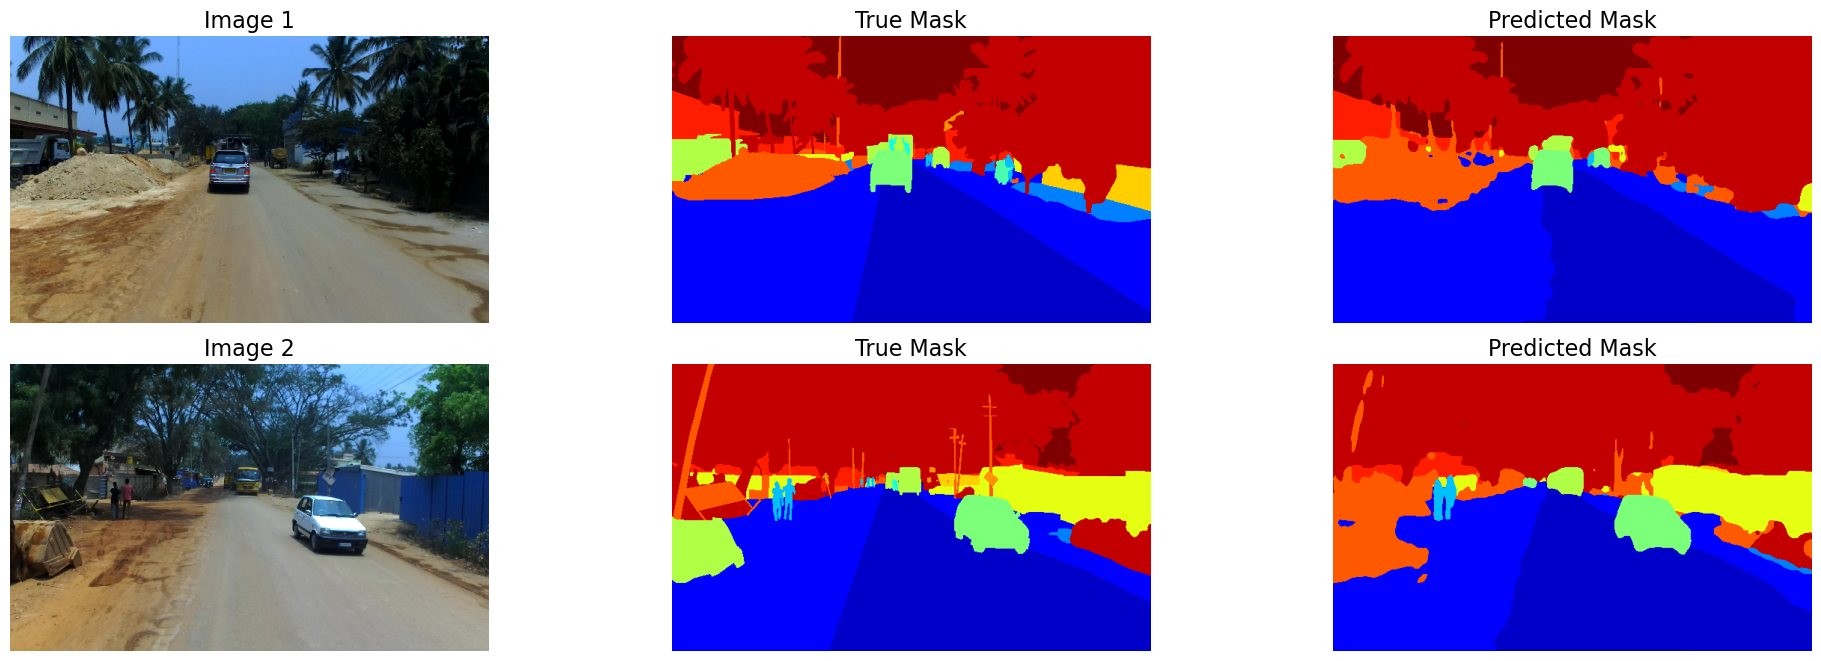

In [35]:
# Take one batch from the dataset
for images, true_masks in val_dataset.take(1):  # Using val_dataset
    # Get model predictions
    pred_masks = model.predict(images, verbose=0)
    
    # For multi-class segmentation with one-hot encoded masks:
    true_masks_argmax = tf.argmax(true_masks, axis=-1)  # Convert one-hot to class indices
    pred_masks_argmax = tf.argmax(pred_masks, axis=-1)  # Model outputs softmax probabilities
    
    # For binary segmentation (if not using one-hot):
    # pred_masks_argmax = (pred_masks > 0.5).astype(np.uint8)  # Threshold at 0.5
    
    # Plot images, true masks, and predictions
    plt.figure(figsize=(20, 10))
    
    for i in range(min(2, len(images))):  # Show first 2 examples
        # Original Image
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow((images[i].numpy() * 255).astype(np.uint8))
        plt.title(f"Image {i+1}", fontsize=16)
        plt.axis('off')
        
        # True Mask
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(true_masks_argmax[i], cmap='jet')
        plt.title("True Mask", fontsize=16)
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(pred_masks_argmax[i], cmap='jet')
        plt.title("Predicted Mask", fontsize=16)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("UNet_output.png", bbox_inches='tight')
    plt.show()

In [28]:
# loading test data to infer
data_test = pd.read_csv('data_test.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 216ms/step


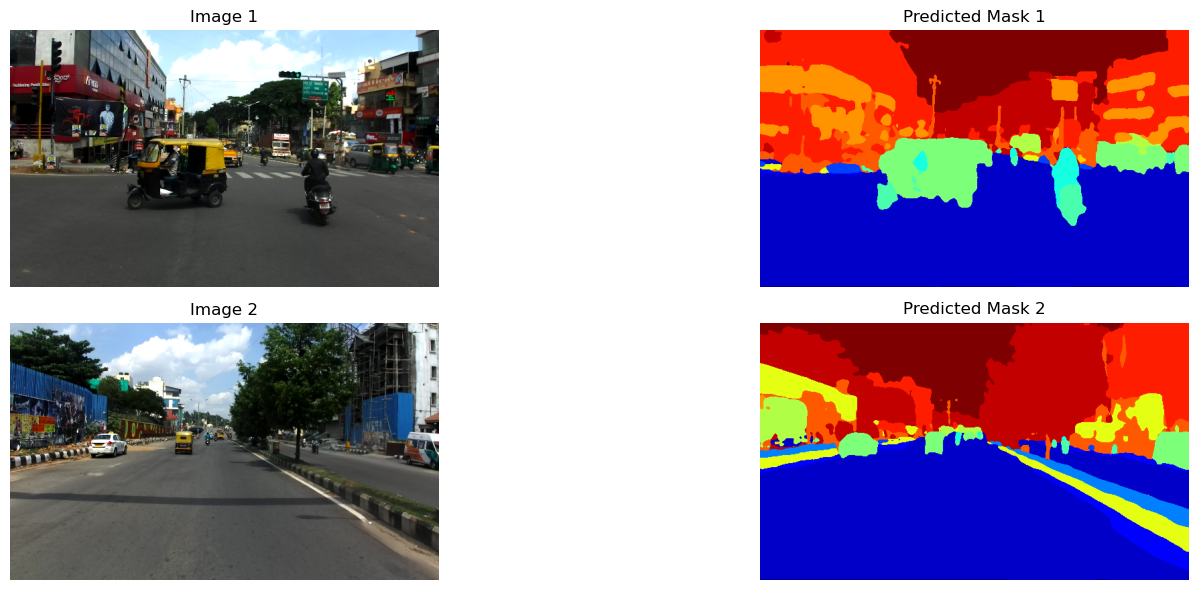

In [50]:
# Take one batch from the test dataset
def load_and_preprocess_image(path):
    # Load image from path
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # or decode_jpeg
    image = tf.image.resize(image, IMG_SIZE)  # IMG_SIZE like (128, 128)
    image = image / 255.0  # normalize to [0,1] if model expects that
    return image

# Prepare batch
batch_paths = data_test.image[:2]  # e.g., first batch
images = tf.stack([load_and_preprocess_image(p) for p in batch_paths])

pred_masks = model.predict(images)
    
# For multi-class segmentation with one-hot encoded masks:
pred_masks_argmax = tf.argmax(pred_masks, axis=-1)  # Model outputs softmax probabilities

# Plot images and predictions
plt.figure(figsize=(18, 6))

for i in range(min(2, len(images))):  # Show first 2 examples
    # Original Image (left column)
    plt.subplot(2, 2, 2*i + 1)
    plt.imshow((images[i].numpy() * 255).astype(np.uint8))
    plt.title(f"Image {i+1}")
    plt.axis('off')
    
    # Predicted Mask (right column)
    plt.subplot(2, 2, 2*i + 2)
    plt.imshow(pred_masks_argmax[i], cmap='jet')
    plt.title(f"Predicted Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()



### 6. Custom CANet Implementation
the difference in my implementation is that i used leaky relu and he_normalization instead of normal relu and glorot_normalization because i had the issue of vanishing gradient

In [41]:
# reloading and reconfiguring for another run
# Configuration
IMG_SIZE = (512,512)
BATCH_SIZE = 4
AUTOTUNE = tf.data.AUTOTUNE
NUM_CLASSES = 18
# Usage:
train_dataset = get_tf_dataset(X_train, y_train, training=True)  # Apply augmentations during training
val_dataset = get_tf_dataset(X_val, y_val, training=False)    # No augmentations during validation

images used from [https://blog.paperspace.com/](https://blog.paperspace.com/understanding-canet-architecture/) <br>
this is the structure of CANet
<img src='https://blog.paperspace.com/content/images/size/w1000/2021/05/image-20.png'>

#### 6.1 Model Design

###### Convolution Block  

<img src="https://blog.paperspace.com/content/images/2021/05/image-44.png">

In [42]:

class convolutional_block(tf.keras.layers.Layer):
    def __init__(self, filters=[4, 4, 8], stride=1, name="conv_block"):
        super().__init__()
        F1, F2, F3 = filters

        # Main path
        self.conv1 = Conv2D(F1, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', name=name+'_conv1')
        self.bn1 = BatchNormalization(name=name+'_bn1')
        self.act1 = Activation('leaky_relu')

        self.conv2 = Conv2D(F2, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv2')
        self.bn2 = BatchNormalization(name=name+'_bn2')
        self.act2 = Activation('leaky_relu')

        self.conv3 = Conv2D(F3, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', name=name+'_conv3')
        self.bn3 = BatchNormalization(name=name+'_bn3')

        # Shortcut path (projection shortcut)
        self.shortcut_conv = Conv2D(F3, kernel_size=3, strides=stride, kernel_initializer='he_normal', padding='same', name=name+'_shortcut_conv')
        self.shortcut_bn = BatchNormalization(name=name+'_shortcut_bn')
        self.shortcut_act = Activation('leaky_relu')

        # Final activation
        self.final_act = Activation('leaky_relu')

    def call(self, x):
        # Main path
        x1 = self.conv1(x)
        x1 = self.bn1(x1)
        x1 = self.act1(x1)

        x1 = self.conv2(x1)
        x1 = self.bn2(x1)
        x1 = self.act2(x1)

        x1 = self.conv3(x1)
        x1 = self.bn3(x1)

        # Shortcut path
        x2 = self.shortcut_conv(x)
        x2 = self.shortcut_bn(x2)
        x2 = self.shortcut_act(x2)

        # Add and final activation
        out = Add()([x1, x2])
        return self.final_act(out)

###### identity Block
<img src="https://blog.paperspace.com/content/images/2021/05/image-21.png">

In [43]:
class identity_block(tf.keras.layers.Layer):
    def __init__(self, filters=[4, 4, 8], stride=1, name="identity_block"):
        super().__init__()
        F1, F2, F3 = filters

        self.conv1 = Conv2D(F1, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', name=name+'_conv1')
        self.bn1 = BatchNormalization(name=name+'_bn1')
        self.act1 = Activation('leaky_relu')

        self.conv2 = Conv2D(F2, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv2')
        self.bn2 = BatchNormalization(name=name+'_bn2')
        self.act2 = Activation('leaky_relu')

        self.conv3 = Conv2D(F3, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', name=name+'_conv3')
        self.bn3 = BatchNormalization(name=name+'_bn3')

        self.final_act = Activation('leaky_relu')

    def call(self, X):
        x = self.conv1(X)
        x = self.bn1(x)
        x = self.act1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.act2(x)

        x = self.conv3(x)
        x = self.bn3(x)

        # Add shortcut and apply final activation
        x = Add()([x, X])
        return self.final_act(x)

###### Global Flow, Context Flow and FSM
<img src='https://blog.paperspace.com/content/images/2021/05/image-22.png'>

In [44]:
class global_flow(tf.keras.layers.Layer):
    def __init__(self, name="global_flow"):
        super().__init__()
        shape = (64, 64)
        self.gp = GlobalAveragePooling2D()
        self.bn = BatchNormalization()
        self.act = Activation('leaky_relu')
        self.conv1 = Conv2D(32, kernel_size=1, strides=1, padding='same', kernel_initializer='he_normal', name=name+'_conv1x1_main')
        self.reshape = Reshape((1, 1, 64))
        self.upsample = UpSampling2D(size=shape, interpolation='bilinear')  # upsample to match input size
        
    def call(self, X):
        x = self.gp(X)                              # shape: (batch, channels)
        x = self.bn(x)
        x = self.act(x)
        x = self.conv1(self.reshape(x))             # shape: (batch, 1, 1, filters)
        x = self.upsample(x)                        # upsampling to (H, W)
        return x

In [45]:
class context_flow(tf.keras.layers.Layer):    
    def __init__(self, filters = 32, stride = 1, N = 2, name="context_flow"):
        super().__init__()

        shape = (64, 64)
        self.ap = AveragePooling2D(N)
        self.conv1 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv3x3_1')
        self.conv2 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv3x3_2')
        self.conv3 = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv1x1_1')
        self.conv4 = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv1x1_2')
        self.act1 = Activation('leaky_relu')
        self.act2 = Activation('sigmoid')
        self.concat = Concatenate()
        self.multiply = Multiply()
        self.add = Add()
        self.upsample = UpSampling2D(size=(2,2), interpolation='bilinear')  # upsample to match input size

    def call(self, X):
        # here X will a list of two elements 
        INP, FLOW = X[0], X[1] 
        
        # Context Fusion
        x1 = self.concat([INP, FLOW])
        x1 = self.ap(x1)
        x1 = self.conv1(x1)
        x1 = self.conv2(x1)
        
        # Context Refinement
        x2 = self.conv3(x1)
        x2 = self.act1(x2)
        x2 = self.conv4(x2)
        x2 = self.act2(x2)

        out = self.multiply([x1, x2])
        out = self.add([x1, out])
        out = self.upsample(out)
        
        return out

In [46]:
class FSM(tf.keras.layers.Layer):    
    def __init__(self, filters = 32, stride = 1, name="feature_selection"):
        super().__init__()
        self.conv1 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv3x3_1')
        self.gp = GlobalAveragePooling2D()
        self.conv2 = Conv2D(filters, kernel_size=1, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv1x1_1')
        self.bn = BatchNormalization()
        self.act = Activation("sigmoid")
        self.multiply = Multiply()
        self.upsample = UpSampling2D(size=(2,2), interpolation='bilinear')
    def call(self, X):
        # implement the FSM module
        x1 = self.conv1(X)                        # (None, H, W, filters)
        x2 = self.gp(x1)                          # (None, filters)
        x2 = tf.expand_dims(tf.expand_dims(x2, 1), 1)  # → (None, 1, 1, filters)
        x2 = self.conv2(x2)
        x2 = self.bn(x2)
        x2 = self.act(x2)

        out = self.multiply([x1,x2])
        out = self.upsample(out)
        return out

###### AGCN
<img src="https://blog.paperspace.com/content/images/2021/05/image-23.png">

In [47]:
class AGCN(tf.keras.layers.Layer):    
    def __init__(self, filters=32, stride=1, name="global_conv_net"):
        super().__init__()
        self.conv1 = Conv2D(filters, kernel_size=(7,1), strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv7x1_1')
        self.conv2 = Conv2D(filters, kernel_size=(1,7), strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv1x7_1')
        self.conv3 = Conv2D(filters, kernel_size=(1,7), strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv1x7_2')
        self.conv4 = Conv2D(filters, kernel_size=(7,1), strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv7x1_2')
        self.add1 = Add()
        self.conv5 = Conv2D(filters, kernel_size=3, strides=stride, padding='same', kernel_initializer='he_normal', name=name+'_conv3x3_1')
        self.add2 = Add()
    def call(self, X):
        x1 = self.conv1(X)
        x1 = self.conv2(x1)
        x2 = self.conv3(X)
        x2 = self.conv4(x2)

        x_short = self.add1([x1,x2])
        x3 = self.conv5(x_short)

        out = self.add2([x_short,x3])
        return out

#### 6.1.1 building the Model

In [48]:
# initialize the input
X_input = Input(shape=(512,512,3))

# initialize the first convolution layer
X = Conv2D(4, (3, 3), name='conv1_first', padding="same", kernel_initializer=glorot_uniform(seed=0))(X_input)
X = BatchNormalization(axis=3, name='bn_conv1')(X)
X = Activation('relu')(X)
X = MaxPooling2D((2, 2), strides=(2, 2))(X)
print(X.shape)

(None, 256, 256, 4)


In [49]:
# defining the model
C1 = convolutional_block(stride=2, filters=[4, 4, 8], name="conv_block1")
C1_idn = identity_block(filters=[4, 4, 8], name="id_block1")

C2 = convolutional_block(stride=2, filters=[8, 8, 16], name="conv_block2")
C2_idn = identity_block(filters=[8, 8, 16], name="id_block2")

C3 = convolutional_block(stride=1, filters=[16, 16, 32], name="conv_block3")
C3_idn = identity_block(filters=[16, 16, 32], name="id_block3")

C4 = convolutional_block(stride=1, filters=[32, 32, 64], name="conv_block4")
C4_idn = identity_block(filters=[32, 32, 64], name="id_block4")

GF = global_flow(name="global_flow")
CF1 = context_flow(name="context_flow1")
CF2 = context_flow(name="context_flow2")
CF3 = context_flow(name="context_flow3")

fsm_layer = FSM(name="fsm")
agcn_layer = AGCN(name="agcn")

conv3_3_final = Conv2D(18, kernel_size=3, strides=1,  padding='same', name='conv3x3_final')
upsample_final = UpSampling2D(size=(4,4), interpolation='bilinear')
act_final = Activation('softmax')

In [50]:
# initialize the layers
X1 = C1(X)
X1 = C1_idn(X1)

X2 = C2(X1)
X2 = C2_idn(X2)

X3 = C3(X2)
X3 = C3_idn(X3)

X4 = C4(X3)
X4 = C4_idn(X4)

GF1 = GF(X4)

CF1 = CF1([X4,GF1])

CF2 = CF2([X4,CF1])

CF3 = CF3([X4,CF2])

added_X = Add()([GF1, CF1, CF2, CF3])
fsm_output = fsm_layer(added_X)

agcn_output = agcn_layer(X1)

fsm_agcn_concat = Concatenate()([fsm_output,agcn_output])

conv3_3_final = conv3_3_final(fsm_agcn_concat)
upsample_final = upsample_final(conv3_3_final)
output = act_final(upsample_final)

In [22]:
# reset the global Keras state
tf.keras.backend.clear_session()

In [23]:
# build the model

model = Model(inputs = X_input, outputs = output)
# the layers
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 512, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_first         │ (None, 512, 512,  │        112 │ input_layer[0][0] │
│ (Conv2D)            │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_conv1            │ (None, 512, 512,  │         16 │ conv1_first[0][0] │
│ (BatchNormalizatio… │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 512, 512,  │          0 │ bn_conv1[0][0]    │
│ (Activation)        │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 256, 256,  │          0 │ activation[0][0]  │
│ (MaxPooling2D)      │ 4)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_block │ (None, 128, 128,  │        600 │ max_pooling2d[0]… │
│ (convolutional_blo… │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ identity_block      │ (None, 128, 128,  │        288 │ convolutional_bl… │
│ (identity_block)    │ 8)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 64, 64,    │      2,160 │ identity_block[0… │
│ (convolutional_blo… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ identity_block_1    │ (None, 64, 64,    │        992 │ convolutional_bl… │
│ (identity_block)    │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 64, 64,    │      8,160 │ identity_block_1… │
│ (convolutional_blo… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ identity_block_2    │ (None, 64, 64,    │      3,648 │ convolutional_bl… │
│ (identity_block)    │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ convolutional_bloc… │ (None, 64, 64,    │     31,680 │ identity_block_2… │
│ (convolutional_blo… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ identity_block_3    │ (None, 64, 64,    │     13,952 │ convolutional_bl… │
│ (identity_block)    │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_flow         │ (None, 64, 64,    │      2,336 │ identity_block_3… │
│ (global_flow)       │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_flow        │ (None, 64, 64,    │     39,040 │ identity_block_3… │
│ (context_flow)      │ 32)               │            │ global_flow[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_flow_1      │ (None, 64, 64,    │     39,040 │ identity_block_3… │
│ (context_flow)      │ 32)               │            │ context_flow[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ context_flow_2      │ (None, 64, 64,    │     39,040 │ identity_block_3

 Total params: 229,178 (895.23 KB)

 Trainable params: 227,778 (889.76 KB)

 Non-trainable params: 1,400 (5.47 KB)

### 6.2 Training the Model

In [24]:
# compiling the model
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss

model.compile(optim, loss = focal_loss, metrics=[IOUScore])

In [25]:
# define callbacks for learning rate scheduling, best checkpoints saving and logging
callbacks = [
    tf.keras.callbacks.ModelCheckpoint('./best_model_CANet.weights.h5', save_weights_only=True, save_best_only=True, \
                                       mode='min', monitor='val_iou_score'),
    tf.keras.callbacks.ReduceLROnPlateau(monitor='val_iou_score', factor = 0.5,min_lr=0.000001,patience=5),
    # Using logger callback for plotting
    CSVLogger('training_log.csv', append=False)
]

In [26]:
# fitting the model
model.fit(train_dataset,  epochs=30,
          validation_data=val_dataset,callbacks=callbacks)

Epoch 1/30


I0000 00:00:1748613906.119648    5480 service.cc:152] XLA service 0x77c694002440 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1748613906.119677    5480 service.cc:160]   StreamExecutor device (0): NVIDIA GeForce RTX 3060, Compute Capability 8.6
I0000 00:00:1748613910.372921    5480 cuda_dnn.cc:529] Loaded cuDNN version 90300


   1/1000 ━━━━━━━━━━━━━━━━━━━━ 14:14:24 51s/step - iou_score: 0.0128 - loss: 1.5040

I0000 00:00:1748613939.905043    5480 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


1000/1000 ━━━━━━━━━━━━━━━━━━━━ 147s 96ms/step - iou_score: 0.1147 - loss: 1.0014 - val_iou_score: 0.1653 - val_loss: 0.8544 - learning_rate: 0.0010
Epoch 2/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 88s 88ms/step - iou_score: 0.1819 - loss: 0.8336 - val_iou_score: 0.1718 - val_loss: 0.8530 - learning_rate: 0.0010
Epoch 3/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 87s 86ms/step - iou_score: 0.2104 - loss: 0.7908 - val_iou_score: 0.1823 - val_loss: 0.8335 - learning_rate: 0.0010
Epoch 4/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 87s 86ms/step - iou_score: 0.2314 - loss: 0.7601 - val_iou_score: 0.2112 - val_loss: 0.7879 - learning_rate: 0.0010
Epoch 5/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 87s 87ms/step - iou_score: 0.2465 - loss: 0.7374 - val_iou_score: 0.2172 - val_loss: 0.7747 - learning_rate: 0.0010
Epoch 6/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 88s 87ms/step - iou_score: 0.2565 - loss: 0.7236 - val_iou_score: 0.2196 - val_loss: 0.7844 - learning_rate: 0.0010
Epoch 7/30
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 89s 89ms/step - iou_

In [27]:
# saving the model for later use just in case training interrupted
model.save_weights("model_CANet.weights.h5")

In [51]:
#Loading the model if needed
model = Model(inputs = X_input, outputs = output)
optim = tf.keras.optimizers.Adam(0.001)
focal_loss = sm.losses.cce_dice_loss
model.compile(optimizer=optim, loss=focal_loss, metrics=[IOUScore])
model.load_weights("model_CANet.weights.h5")

### 6.3 Evaluation

In [28]:
# Evaluate the model on val_dataset
results = model.evaluate(val_dataset, verbose=1)

# Extract IoU score
iou_score = results[1]  # Index 0 is loss, followed by metrics
print(f"IoU Score on Test Set: {iou_score:.4f}")

246/246 ━━━━━━━━━━━━━━━━━━━━ 7s 26ms/step - iou_score: 0.3402 - loss: 0.6311
IoU Score on Test Set: 0.3356


### 6.4 Inference

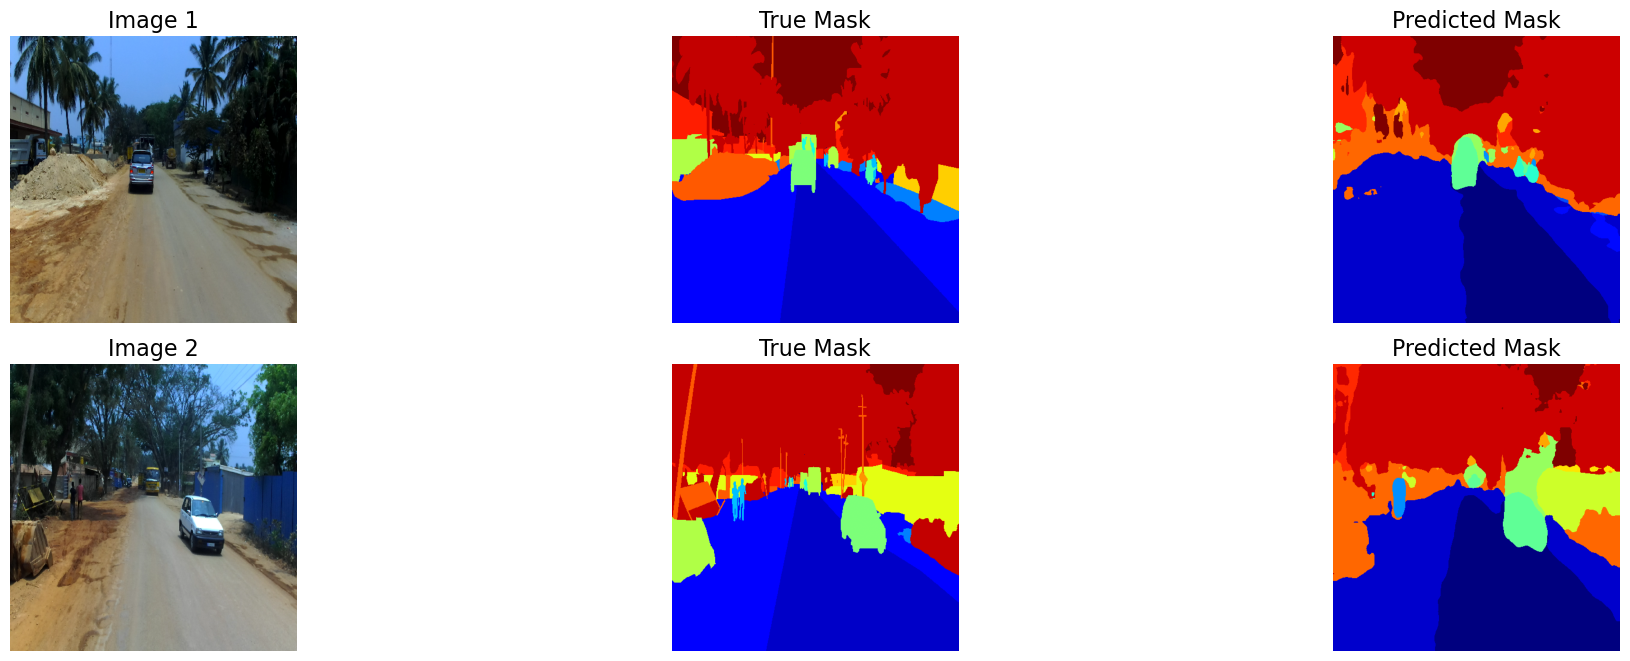

In [53]:
# Take one batch from the dataset
for images, true_masks in val_dataset.take(1):  # Using val_dataset
    # Get model predictions
    pred_masks = model.predict(images, verbose=0)
    
    # For multi-class segmentation with one-hot encoded masks:
    true_masks_argmax = tf.argmax(true_masks, axis=-1)  # Convert one-hot to class indices
    pred_masks_argmax = tf.argmax(pred_masks, axis=-1)  # Model outputs softmax probabilities
    
    # For binary segmentation (if not using one-hot):
    # pred_masks_argmax = (pred_masks > 0.5).astype(np.uint8)  # Threshold at 0.5
    
    # Plot images, true masks, and predictions
    plt.figure(figsize=(20, 10))
    
    for i in range(min(2, len(images))):  # Show first 2 examples
        # Original Image
        plt.subplot(3, 3, i*3 + 1)
        plt.imshow((images[i].numpy() * 255).astype(np.uint8))
        plt.title(f"Image {i+1}", fontsize=16)
        plt.axis('off')
        
        # True Mask
        plt.subplot(3, 3, i*3 + 2)
        plt.imshow(true_masks_argmax[i], cmap='jet')
        plt.title("True Mask", fontsize=16)
        plt.axis('off')
        
        # Predicted Mask
        plt.subplot(3, 3, i*3 + 3)
        plt.imshow(pred_masks_argmax[i], cmap='jet')
        plt.title("Predicted Mask", fontsize=16)
        plt.axis('off')
    plt.tight_layout()
    plt.savefig("CANet_output.png", bbox_inches='tight')
    plt.show()

In [30]:
data_test = pd.read_csv('data_test.csv')

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


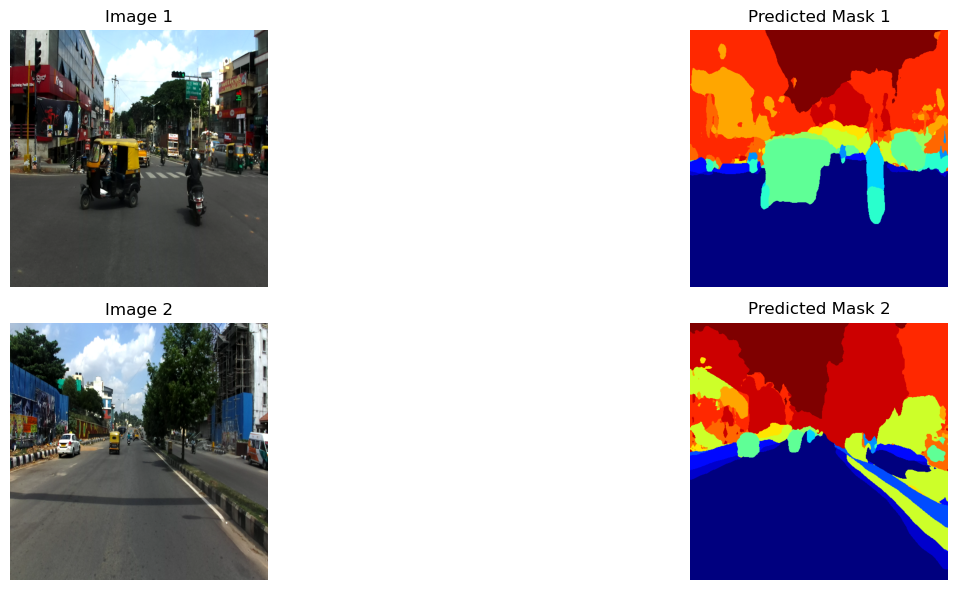

In [31]:
# Take one batch from the test dataset
def load_and_preprocess_image(path):
    # Load image from path
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=3)  # or decode_jpeg
    image = tf.image.resize(image, IMG_SIZE)  # IMG_SIZE like (128, 128)
    image = image / 255.0  # normalize to [0,1] if model expects that
    return image

# Prepare batch
batch_paths = data_test.image[:2]  # e.g., first batch
images = tf.stack([load_and_preprocess_image(p) for p in batch_paths])

pred_masks = model.predict(images)
    
# For multi-class segmentation with one-hot encoded masks:
pred_masks_argmax = tf.argmax(pred_masks, axis=-1)  # Model outputs softmax probabilities

# Plot images and predictions
plt.figure(figsize=(18, 6))

for i in range(min(2, len(images))):  # Show first 2 examples
    # Original Image (left column)
    plt.subplot(2, 2, 2*i + 1)
    plt.imshow((images[i].numpy() * 255).astype(np.uint8))
    plt.title(f"Image {i+1}")
    plt.axis('off')
    
    # Predicted Mask (right column)
    plt.subplot(2, 2, 2*i + 2)
    plt.imshow(pred_masks_argmax[i], cmap='jet')
    plt.title(f"Predicted Mask {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()



In [35]:
def plot_training_history(history_df, acc_key='iou_score', val_acc_key='val_iou_score',
                          loss_key='loss', val_loss_key='val_loss'):
    '''
    Plot the training and validation accuracy and loss
    '''
    # Get the epoch
    epochs = history_df['epoch']

    # Get the figure size
    plt.figure(figsize=(12, 5))

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history_df[loss_key], label='Training Loss')
    plt.plot(epochs, history_df[val_loss_key], label='Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history_df[acc_key], label='Training Accuracy')
    plt.plot(epochs, history_df[val_acc_key], label='Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [36]:
# Load the CSVLogger output
history_df = pd.read_csv('training_log.csv')

# Shift epoch index to start from 1 (optional, for consistency with manual logs)
history_df['epoch'] = history_df.index + 1

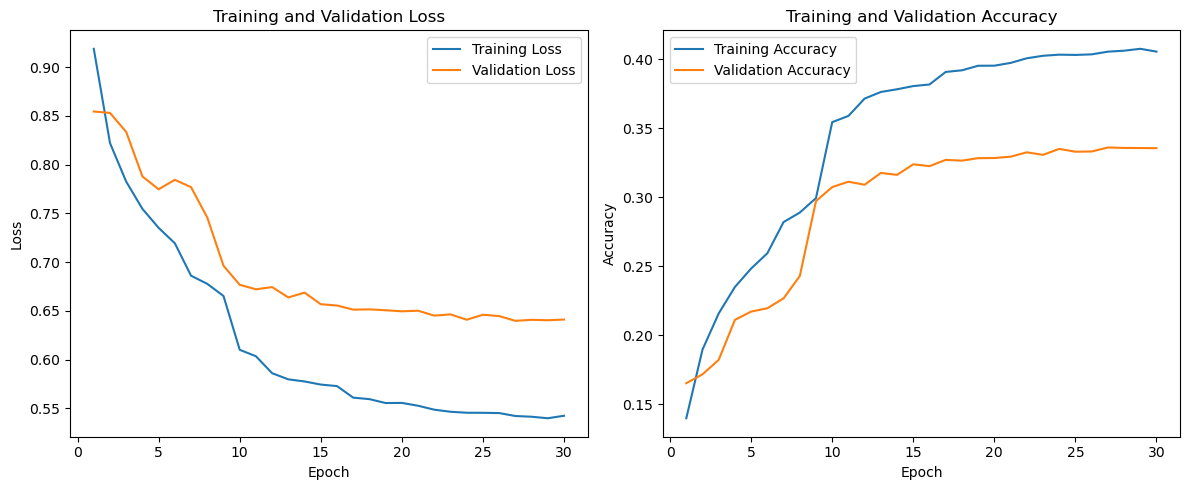

In [38]:
plot_training_history(history_df)

## Evaluation & Results
### Observations:
* The UNet model achieved an IoU score of 49.99%, while the custom CANet model achieved 33.5%.

* The relatively lower performance of CANet can be partially attributed to class imbalance within the dataset.

* CANet's performance can likely be improved by incorporating class-weighted loss functions, oversampling rare classes, or using focal + dice loss to better handle class distribution disparities.

* Additionally, experimenting with network depth, different attention mechanisms, and advanced augmentation strategies may contribute to further performance gains.



## Conclusion
* UNet currently outperforms the custom CANet architecture on the IDD segmentation task in terms of IoU score.

* Addressing class imbalance is a key next step for improving CANet's performance.

* Future work includes enhancing the CANet architecture, tuning hyperparameters, and employing loss functions or data strategies that mitigate class imbalance.

* These improvements are expected to make CANet more competitive and better adapted to real-world segmentation challenges in unstructured traffic environments.

## References / Credits
- [idd.insaan.iiit.ac.in](https://idd.insaan.iiit.ac.in/)
- [Research Paper: U-Net: Convolutional Networks for Biomedical Image Segmentation:](https://arxiv.org/abs/1505.04597)
- [Research Paper: Attention-guided Chained Context Aggregationfor Semantic Segmentation:](https://arxiv.org/pdf/2002.12041)
- [Understanding The CANet Architecture From Scratch:](https://blog.paperspace.com/understanding-canet-architecture/)
- [Indian Traffic Semantic Segmentation.](https://harishkumar-69065.medium.com/indian-traffic-semantic-segmentation-d4a0062c81fc)